### Import libraries

In [9]:
! pip install git+https://github.com/ildoonet/cutmix

  Cloning https://github.com/ildoonet/cutmix to /tmp/pip-req-build-saiwfg0c
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/cutmix /tmp/pip-req-build-saiwfg0c
  Resolved https://github.com/ildoonet/cutmix to commit 1bc006b5f40c284a6bf4ef881906e2109a27ef6c
  Preparing metadata (setup.py) ... done
  Created wheel for cutmix: filename=cutmix-0.1-py3-none-any.whl size=3598 sha256=add742ef1d47b13804f79395ba04517d620a7936e9a9a3ec8dfe846b5c73f964
  Stored in directory: /tmp/pip-ephem-wheel-cache-rwoafvjr/wheels/c1/ad/32/560cafd2fbc9d7a2df4f0bd4f50b4f9d6c9a707bae5034d8b3
Successfully built cutmix
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [10]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from cutmix.cutmix import CutMix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from torchvision.models import resnet18

warnings.filterwarnings("ignore")

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### Load dataset

In [11]:
class RandomRotation:
    """
    Rotate images by random degree chosen from list of angles

    :param angles: list of angles to be 
    :type angles: list
    """
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        """
        Rotate image by random degree

        :param x: image to be transformed
        :type angles: tensor
        """
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)


def load_dataset(batch_size, transform_method):
    """
    Used to load data set with desired transformation and batch size
    
    :param batch_size: set batch_size of train and test data
    :type batch_size: int
    :param transform_method: choose method of transformation dataset
    :type transform_method: str

    :returns: Dataset splited in train and test with desired transformation
    :rtype: torch.utils.data.dataloader.DataLoader
    """

    # Basic transformation which is done for each image
    base = [
            transforms.ToTensor(), 
            transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5)),
    ]

    # More complex transformations chosen on the basis of transform_method parameter
    if transform_method in ["base", "cutmix"]:
        transform = transforms.Compose(
            base
        )
    elif transform_method == "random_rotation":
        transform = transforms.Compose(
            base + [RandomRotation(angles=[-30, -15, 0, 15, 30])]
        )
    elif transform_method == "random_horizontal_flip":
        transform = transforms.Compose(
            base + [transforms.RandomHorizontalFlip(0.2)]
        )
    elif transform_method == "gray_scale":
        transform = transforms.Compose(
            base + [transforms.Grayscale(3)]
        )
    else:
        raise Exception("Transform method not found!")

    # Download and load CIFAR10 dataset
    train_set = torchvision.datasets.CIFAR10(root='./downloaded_data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./downloaded_data', train=False, download=True, transform=transform)

    # If the value of the parameter indicates it, then perform a cutmix transformation
    if transform_method == "cutmix":
        train_set = CutMix(
            train_set, 
            num_class=10, # Liczba klas, w naszym przypadku 10
            beta=1.0, # parametry rozkładu Beta(beta, beta) 
            prob=0.2, # prawdopodobieństwo cutmixa
            num_mix=10,  # liczba zamian
        )

        test_set = CutMix(
            test_set, 
            num_class=10, # Liczba klas, w naszym przypadku 10
            beta=1.0, # parametry rozkładu Beta(beta, beta) 
            prob=0.2, # prawdopodobieństwo cutmixa
            num_mix=10,  # liczba zamian
        )

    # Divide the dataset into batches and perform the shuffling
    train_loader=torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader=torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_loader, test_loader

In [12]:
train_loader, test_loader = load_dataset(batch_size=4, transform_method="base")

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Show example images

In [13]:
def show_image(image):
    image=image/2 +0.5
    img_numpy=image.numpy()
    plt.imshow(np.transpose(img_numpy, (1,2,0)))
    plt.show()

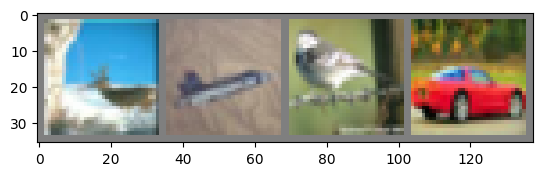

In [11]:
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

In [13]:
labels_str=""
for i in range(4):
    labels_str+=classes[labels[i]]+", "

print(labels_str)

deer, plane, bird, car, 


### Neural network architectures

In [14]:
class SimpleNetBaseline1(nn.Module):
    """
    Simple convolutional neural network defined in our document
    """
    def __init__(self):
        super(SimpleNetBaseline1, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv1 = torch.nn.Conv2d(3,8,5)
        self.conv2 = torch.nn.Conv2d(8,16,5)
   
        self.pool = torch.nn.MaxPool2d(2,2)
        self.flatten = torch.nn.Flatten()
   
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class SimpleNetBaseline2(nn.Module):
    """
    A variant of the simple convolutional network described in our document
    """
    def __init__(self):
        super(SimpleNetBaseline2, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.conv1 = torch.nn.Conv2d(3,8,5)
        self.conv2 = torch.nn.Conv2d(8,16,5)
        
        self.pool = torch.nn.MaxPool2d(2,2)
        self.flatten = torch.nn.Flatten()
        
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 100)
        self.fc2 = torch.nn.Linear(100, 30)
        self.fc3 = torch.nn.Linear(30, 10)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x  

class MoreComplexNet(nn.Module):
    """
    More complex neural network described in our document
    """
    def __init__(self, dropout_p):
        super(MoreComplexNet, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv1 = torch.nn.Conv2d(3,32,3, padding=1)
        self.conv2 = torch.nn.Conv2d(32,32,3, padding=1)
        self.conv3 = torch.nn.Conv2d(32,64,3, padding=1)
        self.conv4 = torch.nn.Conv2d(64,64,3, padding=1)

        self.dropout = torch.nn.Dropout(dropout_p)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.flatten = torch.nn.Flatten()
        
        self.fc1 = torch.nn.Linear(64 * 8 * 8, 64)
        self.fc2 = torch.nn.Linear(64, 10)
        
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.pool(self.relu(self.conv2(self.relu(self.conv1(x)))))
        x = self.dropout(x)
        x = self.pool(self.relu(self.conv4(self.relu(self.conv3(x)))))
        x = self.dropout(x)
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.softmax(self.fc2(x), dim=1)


        return x  

### Train neural networks

In [15]:
def nn_training(
    train_loader,
    test_loader,
    nn_name, 
    nn_type, 
    n_epochs,
    l2,
    learning_rate, 
    momentum,
    dropout_p = 0, 
    is_cutmix=False,
):
    """
    Train neural network with specific hiperparameters and save it in .pth format.
    
    :param train_loader: set batch_size of train and test data
    :type train_loader: torch.utils.data.dataloader.DataLoader
    :param test_loader: set batch_size of train and test data
    :type test_loader: torch.utils.data.dataloader.DataLoader

    :param nn_name: name of .pth file
    :type nn_name: str
    :param nn_type: type of neural network architecture to be used
    :type nn_type: str
    :param n_epochs: number of epochs
    :type nn_type: int

    :param l2: lambda parameter in ridge regularization
    :type l2: double
    :param learning_rate: learning_rate used in SGD optimizer 
    :type learning_rate: double
    :param momentum: momentum used in SGD optimizer, 
        helps accelerate gradients vectors in the right directions
    :type momentum: double
    :param dropout_p: determinates probability of zeroed the element
    :type dropout_p: double, range: [0, 1]
    
    :param is_cutmix: determines whether cutmix transformation is used, 
        useful for counting metrics
    :type is_cutmix: bool

    """
    # Choose desired neural network architecture
    if nn_type == "SimpleNetBaseline1":
        neural_network = SimpleNetBaseline1()
    elif nn_type == "SimpleNetBaseline2":
        neural_network = SimpleNetBaseline2()
    elif nn_type == "MoreComplexNet":
        neural_network = MoreComplexNet(dropout_p)
    elif nn_type == "ResNet_not_pretrained":
        neural_network = resnet18(pretrained=False, device= device)
        neural_network.fc = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            )
    elif nn_type =="ResNet_pretrained":
        neural_network = resnet18(pretrained=True, device= device)
        neural_network.fc = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            )
    else:
        raise Exception("Invalid neural network type!")
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Select an optimizer (in our case SGD) 
    # with specific hyperparameters related to training
    optimizer = optim.SGD(
        neural_network.parameters(), 
        lr=learning_rate, 
        momentum=momentum,
        weight_decay=l2
    )

    # Epochs loop
    for epoch in range(n_epochs):
        train_loss = 0.0
        train_acc = 0.0
        # Batch loop
        for i, data in enumerate(train_loader, 0):
            # Train neural network
            inputs, labels = data
            optimizer.zero_grad()
            outputs = neural_network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # if cutmix, do not take argmax because of the expanded label
            if is_cutmix:
                predicted = outputs.data # predict
            else:
                _, predicted = torch.max(outputs.data, 1) # predict with argmax
                # calculate accuracy
                acc= accuracy_score(labels, predicted)
                train_acc+=acc

            train_loss += loss.item()
            
            # print loss and accuracy on test data every 2000 mini-batches
            if i % 2000 == 1999:    
                # neural_network.eval()
                test_acc = 0.0
                count = 0
                for j, data_test in enumerate (test_loader, 0):
                    input_test, label_test = data_test
                    output_test = neural_network(input_test)
                    if is_cutmix:
                        predicted = outputs.data
                    else:
                        _, predicted = torch.max(output_test.data, 1)
                        acc_test= accuracy_score(label_test, predicted)
                        test_acc += acc_test
                    count +=1
                # printing statistics
                print(f'[{epoch + 1}] loss: {train_loss / 2000:.3f}, train accuracy: {train_acc/2000:.3f}, test accuracy {test_acc/count:.3f} ')
                train_loss = 0.0
                train_acc = 0.0
    
    print('Finished Training')

    # if directory doesnt exists, create it
    directory = f"./trained_nn/{nn_type}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save trained neural network
    torch.save(neural_network.state_dict(), directory + f"/{nn_name}.pth")


In [25]:
nn_training(
    train_loader,
    test_loader,
    nn_name="model1", 
    nn_type="SimpleNetBaseline1", 
    n_epochs = 5, 
    l2=0,
    learning_rate=0.001, 
    momentum=0.9,
)

In [ ]:
nn_training(
    train_loader,
    test_loader,
    nn_name="model1", 
    nn_type="SimpleNetBaseline2", 
    n_epochs = 5, 
    l2=0, 
    learning_rate=0.001, 
    momentum=0.9,
)

In [ ]:
nn_training(
    train_loader,
    test_loader,
    nn_name="model1", 
    nn_type="MoreComplexNet", 
    n_epochs = 5, 
    l2=0.1,
    learning_rate=0.001, 
    momentum=0.9,
    dropout_p=0.2,
)

In [ ]:
nn_training(
    train_loader,
    test_loader,
    nn_name="model1", 
    nn_type="ResNet_not_pretrained", 
    n_epochs = 1, 
    l2=0.1,
    learning_rate=0.001, 
    momentum=0.9,
)

### Load trained neural networks

In [16]:
def load_model(nn_name, nn_type):
    """
    Load trained model from local files
    
    :param nn_name: name of .pth file
    :type batch_size: str
    :param nn_type: architecture of the loaded neural network
    :type nn_type: str

    :returns: Neural network
    :rtype: torch.nn.Module
    """
    # Choose desired neural network architecture
    if nn_type == "SimpleNetBaseline1":
        net = SimpleNetBaseline1()
    elif nn_type == "SimpleNetBaseline2":
        net = SimpleNetBaseline2()
    elif nn_type == "MoreComplexNet":
        net = MoreComplexNet()
    elif nn_type == "ResNet_not_pretrained":
        net = resnet18(pretrained=False, device= device)
        net.fc = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            )
    elif nn_type =="ResNet_pretrained":
        net = resnet18(pretrained=True, device= device)
        net.fc = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            )
    else:
        raise Exception("Invalid neural network type!")
    
    # Load neural network
    directory = f"./trained_nn/{nn_type}"
    net.load_state_dict(torch.load(directory + f"/{nn_name}.pth"))
    net.eval()

    return net

In [34]:
nn_simple1 = load_model(
    nn_name="model1", 
    nn_type="SimpleNetBaseline1",
)

nn_resnet_pretrained = load_model(
    nn_name="model1", 
    nn_type="ResNet_pretrained",
)

### Results of training

In [17]:
def compute_acc_conf(neural_net):
    """
    Calculate acccuracy and confusion matrix on test data 
    
    :param neural_network: trained neural network
    :type neural_network: torch.nn.Module
    """
    neural_net.eval()
    test_acc = 0.0
    count = 0
    all_labels_test=[]
    all_predictions_test=[]
    for j, data_test in enumerate (test_loader, 0):
        input_test, label_test = data_test
        label_test_np = label_test.detach().numpy()
        output_test = neural_net(input_test)
        _, predicted = torch.max(output_test.data, 1)
        for k in range (len(label_test)):
            all_labels_test.append(label_test[k].item())
            all_predictions_test.append(predicted[k].item())
        count +=1
    acc_test = accuracy_score(all_labels_test, all_predictions_test)
    conf_matrix = confusion_matrix(all_labels_test, all_predictions_test, normalize='true')
    return acc_test, conf_matrix

def make_heatmap(conf_matrix):
    """
    Convert confusion matrix to fine-looking heatmap and show it
    
    :param conf_matrix: confusion matrix 
    :type conf_matrix: ndarray of shape (n_classes, n_classes)
    """
    ax = sns.heatmap(
                conf_matrix*100, 
                linewidth=0.5, 
                xticklabels=classes, 
                yticklabels=classes,
                cmap="crest",  #Blues
                annot=True, fmt='.1f',
                cbar_kws={'label': "Percent of data"})
    ax.set_ylabel("True class")
    ax.set_xlabel("Predicted class")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
    plt.show()

In [29]:
acc_test_simple1, conf_matrix_simple1 = compute_acc_conf(nn_simple1)
acc_test_resnet_pretrained, conf_matrix_resnet_pretrained = compute_acc_conf(nn_resnet_pretrained)

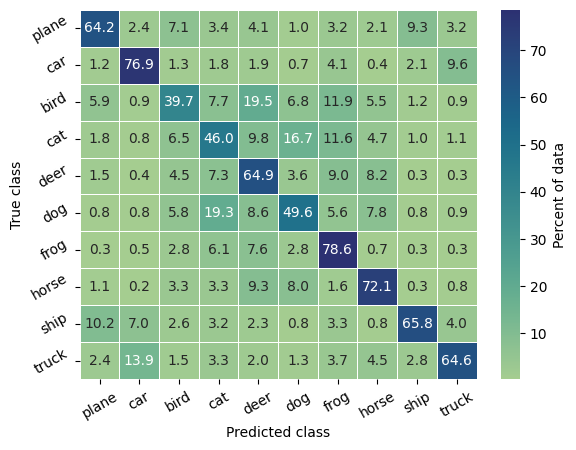

In [30]:
make_heatmap(conf_matrix_simple1)

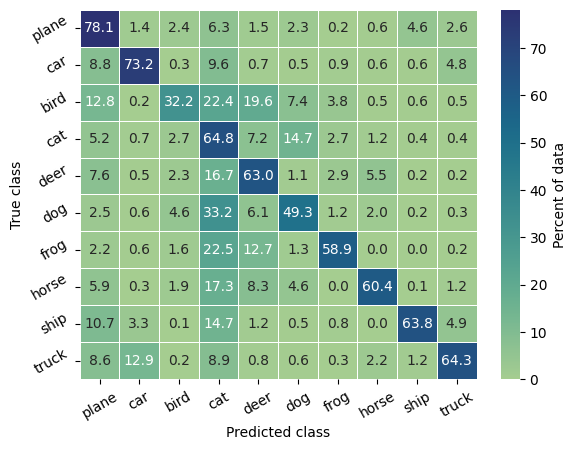

In [ ]:
make_heatmap(conf_matrix_resnet_pretrained)

### Train models with data augmentation

#### Random rotation

In [ ]:
train_loader, test_loader = load_dataset(
    batch_size=4, 
    transform_method="random_rotation",
)

nn_training(
    train_loader,
    test_loader,
    nn_name="model_random_rotation", 
    nn_type="SimpleNetBaseline1", 
    n_epochs = 1, 
    l2=0.1, # lambda w regularyzacji l2
    learning_rate=0.001, 
    momentum=0.9,
)

#### Random horizontal flip

In [ ]:
train_loader, test_loader = load_dataset(
    batch_size=4, 
    transform_method="random_horizontal_flip",
)

nn_training(
    train_loader,
    test_loader,
    nn_name="model_random_horizontal_flip", 
    nn_type="SimpleNetBaseline1", 
    n_epochs = 1, 
    l2=0.1, # lambda w regularyzacji l2
    learning_rate=0.001, 
    momentum=0.9,
)

#### Gray scale

In [ ]:
train_loader, test_loader = load_dataset(
    batch_size=4, 
    transform_method="gray_scale",
)

nn_training(
    train_loader,
    test_loader,
    nn_name="model_gray_scale", 
    nn_type="SimpleNetBaseline1", 
    n_epochs = 1, 
    l2=0.1, # lambda w regularyzacji l2
    learning_rate=0.001, 
    momentum=0.9,
)

#### Cutmix

In [ ]:
train_loader, test_loader = load_dataset(
    batch_size=4, 
    transform_method="cutmix",
)

nn_training(
    train_loader,
    test_loader,
    nn_name="model_cutmix", 
    nn_type="SimpleNetBaseline1", 
    n_epochs = 1, 
    l2=0.1, # lambda w regularyzacji l2
    learning_rate=0.001, 
    momentum=0.9,
    is_cutmix=True,
)

### Experiments for hyperparameters and augumentation

Simple net

In [21]:
# tu trzeba puścić jeszcze raz wszystkie wersje dla cutmix, bo flagi nie ustawiłam dobrze xD


batch_sizes=[4,8,16,32]
learning_rates=[0.001, 0.01, 0.05, 0.1]
#no dropout, as simple net do not have it
transformations=["base", "random_rotation", "random_horizontal_flip", "gray_scale", "cutmix"]
lambda_l2=[0.1, 0.001, 0.0001, 0]
iteration =1
epochs=10
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for transformation in transformations:
            for l2 in lambda_l2:
                if transformation=="cutmix":
                    flag_if_cutmix=True
                else: 
                    flag_if_cutmix=False

                #load dataset
                train_loader, test_loader = load_dataset(
                    batch_size=batch_size, 
                    transform_method=transformation,
                )
                #train and save model
                nn_training(
                    train_loader,
                    test_loader,
                    nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}', 
                    nn_type="SimpleNetBaseline1", 
                    n_epochs = epochs, 
                    l2=l2,
                    learning_rate=learning_rate, 
                    momentum=0.9,
                )

                print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}')

Files already downloaded and verified
Files already downloaded and verified


Wersja tylko cutmix

In [ ]:
batch_sizes=[4,8,16,32]
learning_rates=[0.001, 0.01, 0.05, 0.1]
#no dropout, as simple net do not have it
transformations=[ "cutmix"]
lambda_l2=[0.1, 0.001, 0.0001, 0]
iteration =1
epochs=10
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for transformation in transformations:
            for l2 in lambda_l2:
                if transformation=="cutmix":
                    flag_if_cutmix=True
                else: 
                    flag_if_cutmix=False

                #load dataset
                train_loader, test_loader = load_dataset(
                    batch_size=batch_size, 
                    transform_method=transformation,
                )
                #train and save model
                nn_training(
                    train_loader,
                    test_loader,
                    nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}', 
                    nn_type="SimpleNetBaseline1", 
                    n_epochs = epochs, 
                    l2=l2,
                    learning_rate=learning_rate, 
                    momentum=0.9,
                    is_cutmix=flag_if_cutmix
                )

                print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}')

Complex CNN

In [ ]:
batch_sizes=[4,8,16]
learning_rates=[0.001, 0.01, 0.1]
dropouts = [0.2, 0.4, 0.6]
transformations=["base", "random_rotation", "random_horizontal_flip", "gray_scale", "cutmix"]
lambda_l2=[0.1, 0.001, 0.0001]
iteration =1
epochs=10
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for dropout in dropouts:
            for transformation in transformations:
                for l2 in lambda_l2:
                    if transformation=="cutmix":
                        flag_if_cutmix=True
                    else: 
                        flag_if_cutmix=False

                    #load dataset
                    train_loader, test_loader = load_dataset(
                        batch_size=batch_size, 
                        transform_method=transformation,
                    )
                    #train and save model
                    nn_training(
                        train_loader,
                        test_loader,
                        nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}', 
                        nn_type="MoreComplexNet", 
                        n_epochs = epochs, 
                        l2=l2,
                        learning_rate=learning_rate, 
                        momentum=0.9,
                        dropout_p=dropout,
                        is_cutmix=flag_if_cutmix
                    )

                    print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}')

ResNet18 not pre-trained

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=df32a7ea-133e-49c1-8b06-62e24dc258a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [ ]:
batch_sizes=[4,16]
learning_rates=[0.001, 0.01, 0.1]
# dropouts = [0.4, 0.6]
transformations=["base", "random_rotation", "random_horizontal_flip", "gray_scale", "cutmix"]
lambda_l2=[0.001, 0.0001]
iteration =1
epochs=10
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        # for dropout in dropouts:
        for transformation in transformations:
            for l2 in lambda_l2:
                if transformation=="cutmix":
                    flag_if_cutmix=True
                else: 
                    flag_if_cutmix=False

                #load dataset
                train_loader, test_loader = load_dataset(
                    batch_size=batch_size, 
                    transform_method=transformation,
                )
                #train and save model
                nn_training(
                    train_loader,
                    test_loader,
                    nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}', 
                    nn_type="ResNet_not_pretrained", 
                    n_epochs = epochs, 
                    l2=l2,
                    learning_rate=learning_rate, 
                    momentum=0.9,
                    # dropout_p=dropout,
                    is_cutmix=flag_if_cutmix
                )

                print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}')

ResNet18 pre-trained

In [ ]:
batch_sizes=[4,16]
learning_rates=[0.001, 0.01, 0.1]
# dropouts = [0.4, 0.6]
transformations=["base", "random_rotation", "random_horizontal_flip", "gray_scale", "cutmix"]
lambda_l2=[0.001, 0.0001]
iteration =1
epochs=10
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        # for dropout in dropouts:
        for transformation in transformations:
            for l2 in lambda_l2:
                if transformation=="cutmix":
                    flag_if_cutmix=True
                else: 
                    flag_if_cutmix=False

                #load dataset
                train_loader, test_loader = load_dataset(
                    batch_size=batch_size, 
                    transform_method=transformation,
                )
                #train and save model
                nn_training(
                    train_loader,
                    test_loader,
                    nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}', 
                    nn_type="ResNet_pretrained", 
                    n_epochs = epochs, 
                    l2=l2,
                    learning_rate=learning_rate, 
                    momentum=0.9,
                    # dropout_p=dropout,
                    is_cutmix=flag_if_cutmix
                )

                print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}')